# Final Assignment Supervised learning

## information
    Thijs Kok
    348224
    DSLS


## Justification of dataset

I chose to use the parkinsons dataset because:

- It's easily available

- It has documentation about the data

- It's interesting to look at the comparison between vocal data and parkinsons

- I think the dataset is usefull to train classifiers on because it has binary choices (i.e. either 0 or 1)

- My grandmother had parkinsons


## information on the data

Attribute Information:

Matrix column entries (attributes):
- name - ASCII subject name and recording number
- MDVP:Fo(Hz) - Average vocal fundamental frequency
- MDVP:Fhi(Hz) - Maximum vocal fundamental frequency
- MDVP:Flo(Hz) - Minimum vocal fundamental frequency
- MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP - Several 
- measures of variation in fundamental frequency
- MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA - Several measures of variation in amplitude
- NHR,HNR - Two measures of ratio of noise to tonal components in the voice
- status - Health status of the subject (one) - Parkinson's, (zero) - healthy
- RPDE,D2 - Two nonlinear dynamical complexity measures
- DFA - Signal fractal scaling exponent
- spread1,spread2,PPE - Three nonlinear measures of fundamental frequency variation 

## Choice of algorithms

Since the question we're looking for is the prediction of parkinsons based on vocal recordings, this is a classification problem.

the techniques used will be: 

- logistic regression
- decision trees
- ensemble learning


### Initialisation

In [686]:
import requests as req
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import sklearn as sk
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


# bokeh imports for the heatmap plotting
#import bokeh and direct the output to the notebook
from bokeh.io import output_notebook
output_notebook()
from bokeh.layouts import gridplot
from bokeh.plotting import figure, output_file, show
from bokeh.models import (BasicTicker, ColorBar, ColumnDataSource,
                          LinearColorMapper, PrintfTickFormatter,)
from bokeh.transform import transform
from bokeh.palettes import Viridis256
from bokeh.models import ColumnDataSource


Loading BokehJS ...

### Downloading the data
The data is obtained from: http://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/parkinsons.data

I got this data from:
*'Exploiting Nonlinear Recurrence and Fractal Scaling Properties for Voice Disorder Detection', 
Little MA, McSharry PE, Roberts SJ, Costello DAE, Moroz IM. 
BioMedical Engineering OnLine 2007, 6:23 (26 June 2007)*

In [687]:
# download the parkingson data from: http://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/parkinsons.data
try:
    response = req.get('http://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/parkinsons.data', timeout=2.50)
    with open(file='data/parkinsons.data', mode= 'w', encoding='utf-8') as data_file:
        data_file.write(response.text)
except Exception as e:
    print(f'{e}')

### Load & inspect the data

We know that the 'status' column contains the information wether or not someone has parkinsons.
This will be our 'y' value for the classifiers

In [688]:
data = pd.read_csv('data/parkinsons.data', sep=',')
data.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


#### check if there are any missing values

In [689]:
print(data.isnull().sum())

name                0
MDVP:Fo(Hz)         0
MDVP:Fhi(Hz)        0
MDVP:Flo(Hz)        0
MDVP:Jitter(%)      0
MDVP:Jitter(Abs)    0
MDVP:RAP            0
MDVP:PPQ            0
Jitter:DDP          0
MDVP:Shimmer        0
MDVP:Shimmer(dB)    0
Shimmer:APQ3        0
Shimmer:APQ5        0
MDVP:APQ            0
Shimmer:DDA         0
NHR                 0
HNR                 0
status              0
RPDE                0
DFA                 0
spread1             0
spread2             0
D2                  0
PPE                 0
dtype: int64


As we can see from the cell above, there appears to be no missing data.


In [690]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              195 non-null    object 
 1   MDVP:Fo(Hz)       195 non-null    float64
 2   MDVP:Fhi(Hz)      195 non-null    float64
 3   MDVP:Flo(Hz)      195 non-null    float64
 4   MDVP:Jitter(%)    195 non-null    float64
 5   MDVP:Jitter(Abs)  195 non-null    float64
 6   MDVP:RAP          195 non-null    float64
 7   MDVP:PPQ          195 non-null    float64
 8   Jitter:DDP        195 non-null    float64
 9   MDVP:Shimmer      195 non-null    float64
 10  MDVP:Shimmer(dB)  195 non-null    float64
 11  Shimmer:APQ3      195 non-null    float64
 12  Shimmer:APQ5      195 non-null    float64
 13  MDVP:APQ          195 non-null    float64
 14  Shimmer:DDA       195 non-null    float64
 15  NHR               195 non-null    float64
 16  HNR               195 non-null    float64
 1

Let's see if the data is correlated.

In [691]:
c = data.corr().abs()
y_range = (list(reversed(c.columns)))
x_range = (list(c.index))
#plot a heatmap


#reshape
dfc = pd.DataFrame(c.stack(), columns=['r']).reset_index()
#create colormapper 

#transfer to ColumnDataSource object
source = ColumnDataSource(dfc)
mapper = LinearColorMapper(palette=Viridis256, low=dfc.r.min(), high=dfc.r.max())

#create plot
p = figure(title="correlation heatmap", plot_width=500, plot_height=450,
           x_range=x_range, y_range=y_range, x_axis_location="above", toolbar_location=None)

#use mapper to fill the rectangles in the plot
p.rect(x="level_0", y="level_1", width=1, height=1, source=source,
       line_color=None, fill_color=transform('r', mapper))

#create and add colorbar to the right
color_bar = ColorBar(color_mapper=mapper, location=(0, 0),
                     ticker=BasicTicker(desired_num_ticks=len(x_range)), 
                     formatter=PrintfTickFormatter(format="%.1f"))
p.add_layout(color_bar, 'right')

#draw axis
p.axis.axis_line_color = None
p.axis.major_tick_line_color = None
p.axis.major_label_text_font_size = "10px"
p.axis.major_label_standoff = 0
p.xaxis.major_label_orientation = 1.0

#show
show(p)

print(c['status'].sort_values())

MDVP:Fhi(Hz)        0.166136
NHR                 0.189429
DFA                 0.231739
Jitter:DDP          0.266646
MDVP:RAP            0.266668
MDVP:Jitter(%)      0.278220
MDVP:PPQ            0.288698
RPDE                0.308567
MDVP:Jitter(Abs)    0.338653
D2                  0.340232
Shimmer:DDA         0.347608
Shimmer:APQ3        0.347617
MDVP:Shimmer(dB)    0.350697
Shimmer:APQ5        0.351148
HNR                 0.361515
MDVP:APQ            0.364316
MDVP:Shimmer        0.367430
MDVP:Flo(Hz)        0.380200
MDVP:Fo(Hz)         0.383535
spread2             0.454842
PPE                 0.531039
spread1             0.564838
status              1.000000
Name: status, dtype: float64


There are some correlated values in the dataset, but we're most interested in the correlation between 'status' and other parameters.

so far it does not seem that there are highly correlated parameters for the status parameter(no really light or yellow intersections). however, it does appear that most parameters have a correlation of around .3 to .5 with the status parameter.

As we can see, the 'spread1', 'spread2', and 'PPE' have the highest correlation with the status parameter. I will make several different datasets which contain: 
- dataset 1: R > 0.4
- dataset 2: R > 0.3
- dataset 3: == normal dataset, this will be the reference model


We drop the name column and set the status column as the y axis, before dropping it as well.


In [692]:
y = data.status.values

data.drop(['status', 'name'], axis=1, inplace = True)

X_full = data.values


names_high = c[c['status'] > 0.4].index
X_high = data[names_high[1:]].values

names_middle = c[c['status'] > 0.3].index
X_middle = data[names_high[1:]].values


# I took all the code for scaling and selecting features and put it all in a single function.
def feature_selector(data_frame = data, r=1):
    names = c[c['status'] >= r].index
    print(f'The following columns have a correlation score above {r}:\n{names}')
    X = data_frame[names[1:]].values
    print(f'X-shape = {X.shape}, y-shape = {y.shape}')
    scaler = StandardScaler()
    scaler = scaler.fit(X)
    X = scaler.transform(X)
    return train_test_split(X, y, test_size=0.3, random_state=1)


In [693]:
print(f'X-shape = {X.shape}, y-shape = {y.shape}')

X-shape = (195, 22), y-shape = (195,)


As we can see, y has the shape '195,' which needs to be reshaped to be '195,1'

In [694]:
y = y.reshape(-1,1)

In [695]:
y.shape

(195, 1)

Now we need to normalize the data to prevent higher numbers to affect the outcome of the algorithms. 

For this i use the standardscaler from scikit-learn

In [696]:
scaler = StandardScaler()
scaler = scaler.fit(X)
X = scaler.transform(X)

Now that the data is scaled we split the data into training data and into test data! for this we use a 70/30 ratio, so we have a decent amount of data to test with while still keeping enough to teach the algorithm

In [697]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
X_high_train, X__high_test, y_train, y_test = train_test_split(X_high, y, test_size=0.3, random_state=1)
X_middle_train, X_middle_test, y_train, y_test = train_test_split(X_middle, y, test_size=0.3, random_state=1)

## Training the models

logistic regression:


In [698]:
m,n = X.shape
theta = np.zeros(n)
theta = np.reshape(theta, (n,1))


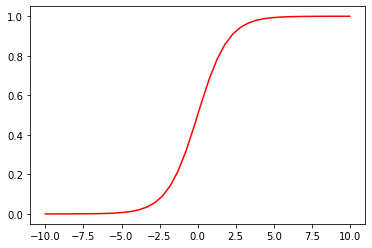

In [699]:
def sigmoid(z):
    '''
    implementation of the sigmoid function
    '''
    return 1 / (1 + np.exp(-z))

def prediction(theta, X):
    '''
    feed the linear regression model into the sigmoid function
    '''
    return sigmoid(np.dot(X, theta.T))

# check the sigmoid curve
nums = np.linspace(-10, 10, 40)
plt.plot(nums, sigmoid(nums), 'r')
plt.show()


In [700]:
def computeCost(theta, X, y):
    '''
    Cost function for the regression model
    '''
    m,n = X.shape
    # theta = np.reshape(theta, (1,n))
    pred = prediction(theta, X)
    J = (y * np.log(pred) + (1-y) * np.log(1-pred))
    return np.mean(-J)

def gradient(theta, X, y):
    '''
    return the derivative for gradient descent
    '''
    m,n = X.shape
    theta = theta.reshape(1,n)
    error = sigmoid(np.dot(X,  theta.T)) - y

    return np.dot(error.T, X)/m

In [710]:
# perform the gradient descent
# result = opt.fmin_tnc(func=computeCost, x0=theta, fprime=gradient, args=(X_train, y_train))
# print(result)

from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=42).fit(X_train, y_train)
clf.score(X_test, y_test)

c:\Users\thijs\anaconda3\envs\supervised_machine_learning_ds4\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8135593220338984